<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/solutions/hw2_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp -r drive/My\ Drive/dul/* .

In [6]:
!mkdir -p deepul/homeworks/hw2/data/

In [7]:
!mv data/* deepul/homeworks/hw2/data/

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [8]:
'''!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul'''

'!if [ -d deepul ]; then rm -Rf deepul; fi\n!git clone https://github.com/rll/deepul.git \n!pip install ./deepul'

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.autonotebook import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

from deepul.hw2_helper import *

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


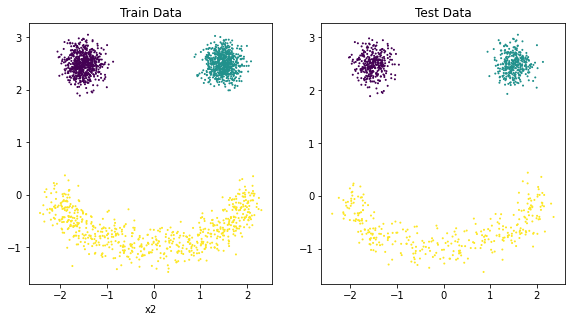

Dataset 2


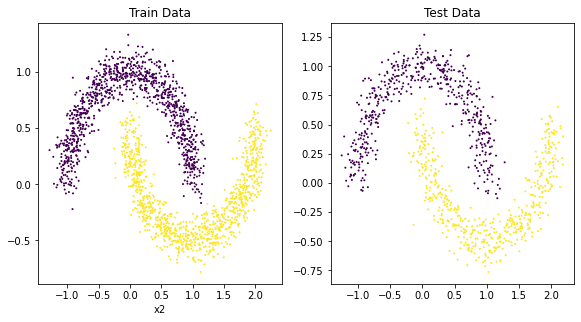

In [6]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Autoregressive Flow [15pt]

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d p(z_i) + log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Show a heatmap of the densities learned by your model
4. Show what the training set looks like when mapped to the latent space. 




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [7]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, num_epochs=10, lr=1e-2, clip_grad=2):
        self.model = model
        self.optimizer = Adam(model.parameters(), lr)
        self.lr = lr
        self.clip_grad = clip_grad
        self.num_epochs = num_epochs
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        train_losses = []
        test_losses = [self.eval_epoch()]
        pbar = tqdm(range(self.num_epochs), total=self.num_epochs)
        for epoch in pbar:
            epoch_losses = self.train_epoch()
            train_losses.extend(epoch_losses)

            test_loss = self.eval_epoch()
            test_losses.append(test_loss)
            
            pbar.set_postfix_str(f'Epoch #{epoch}, test loss: {test_loss:.4f}')

        return train_losses, test_losses

    def train_epoch(self):
        self.model.train()
        
        train_losses = []
        for x in self.train_loader:
            loss = self.model.compute_loss(x.to(device).contiguous())
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)
            self.optimizer.step()

            train_losses.append(loss.item())
        return train_losses

    def eval_epoch(self):
        self.model.eval()

        total_loss = 0
        with torch.no_grad():
            for x in self.test_loader:
                loss = self.model.compute_loss(x.to(device).contiguous())
                total_loss += loss * x.shape[0]

        return (total_loss / len(self.test_loader.dataset)).item()

In [8]:
class CDFMixture(nn.Module):
    def __init__(self, n_components=4):
        super().__init__()
        self.n_comp = n_components

        self.loc = nn.Parameter(torch.randn(n_components))
        self.log_scale = nn.Parameter(torch.zeros(n_components))
        self.w_logits = nn.Parameter(torch.zeros(n_components))
        
    def forward(self, x):
        loc, log_scale, w_logits = self.loc, self.log_scale, self.w_logits

        distr_mix = Normal(loc, torch.exp(log_scale)) 
        w = F.softmax(w_logits, dim=0)[None, :].repeat(x.size(0), 1)
        
        return self.get_z_log(distr_mix, w, x[:, None].repeat(1, self.n_comp))
        
    @staticmethod
    def get_z_log(distr, w, x):
        cdf = distr.cdf(x)
        log_prob = distr.log_prob(x) 

        return torch.sum(cdf * w, dim=1), torch.sum(log_prob.exp() * w, dim=1).log()


class AutoregFlow(nn.Module):
    def __init__(self,
                 n_comp_1=5,
                 n_comp_2=5,
                 hidden_size=64):
        super().__init__()
        self.flow_1 = CDFMixture(n_comp_1).to(device)
        
        self.mlp = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_comp_2 * 3),
        ).to(device)

        self.n_comp = n_comp_2
        self.distr = Uniform(torch.tensor(0.0, device=device), torch.tensor(1.0, device=device))
        self.distr_mix = Normal

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)

        z1, log_1 = self.flow_1(x1.squeeze())
        
        loc, log_scale, w_logits = torch.chunk(self.mlp(x1.float()), 3, dim=1)
        distr_mix = Normal(loc, torch.exp(log_scale)) 
        
        w = F.softmax(w_logits, dim=1)
        z2, log_2 = self.flow_1.get_z_log(distr_mix, w, x2.repeat(1, self.n_comp))

        return (
               torch.cat([z1[:, None], z2[:, None]], dim=1), 
               torch.cat([log_1[:, None], log_2[:, None]], dim=1)
        )

    def log_prob(self, x):
        z, log_ = self(x)
        return torch.mean(self.distr.log_prob(z) + log_, dim=1)

    def compute_loss(self, x):
        return -self.log_prob(x).mean()

In [9]:
def q1_a(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """
  train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=512)

  model = AutoregFlow()
  trainer = Trainer(model, train_loader, test_loader, 100, 1e-2)
  train_losses, test_losses = trainer.train()
 
  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(device)
  densities = np.exp(model.log_prob(mesh_xs).to('cpu').detach().numpy())

  # latents
  z, _ = model(torch.FloatTensor(train_data).to(device))
  latents = z.to('cpu').detach().numpy()

  return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results




Final Test Loss: 0.6674


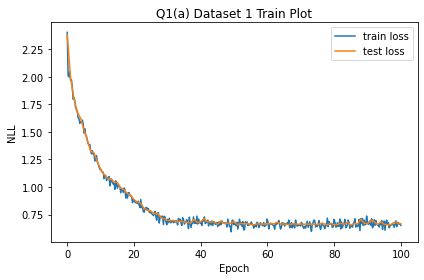

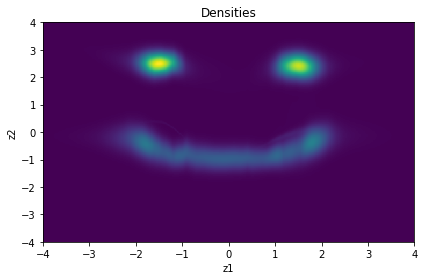

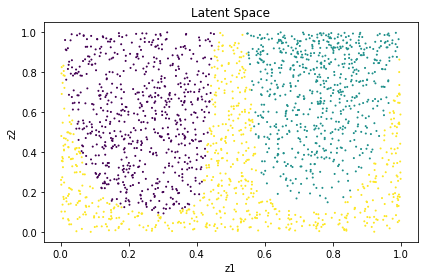

In [10]:
q1_save_results(1, 'a', q1_a)


Final Test Loss: 0.5230


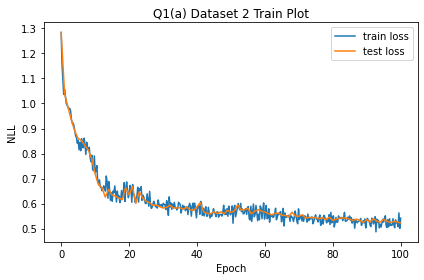

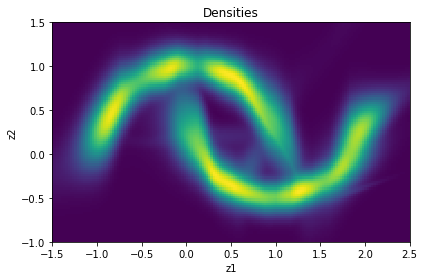

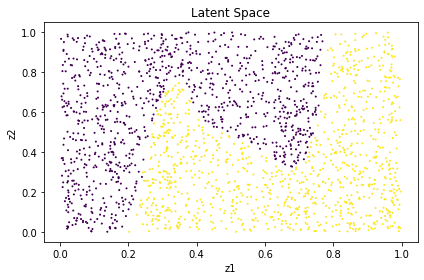

In [11]:
q1_save_results(2, 'a', q1_a)